In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime

# data_o = pd.read_csv('./0506-0_v1.csv')
data = pd.read_csv('./0506-0_v2.csv')
#메인컴 'C:/0_Personal/LSTM/0506-0_v2.csv'
#연구실 'C:/Project/LSTM_proj/0506-0_v2.csv'
data.head()

,DateTime,Elasped_Time(sec),CH 5,CH 6,CH 7,CH 8,CH 8-2,CH 8-3,CH 9,CH 10
0,2020-05-07 01-12-27,1,98.7,48.8,0.0,-3111.75,341.07,0.00,0.00,0
1,2020-05-07 01-12-28,2,94.0,114.4,0.0,-3108.83,343.99,2.92,2.92,0
2,2020-05-07 01-12-29,3,96.9,122.9,0.0,-3102.81,350.01,8.94,6.02,0
3,2020-05-07 01-12-30,4,96.7,71.2,0.0,-3101.25,351.57,10.50,1.56,0
4,2020-05-07 01-12-31,5,91.2,50.3,0.0,-3100.59,352.23,11.16,0.66,0


       rotation   feed  velocity  label
0          98.7   48.8      0.00      0
1          94.0  114.4      2.92      0
2          96.9  122.9      6.02      0
3          96.7   71.2      1.56      0
4          91.2   50.3      0.66      0
...         ...    ...       ...    ...
11269      99.0   42.0      2.00      0
11270      96.7   40.3      3.00      0
11271      94.9   41.2      2.00      0
11272      97.1   42.8      3.00      0
11273     100.4   43.1      3.00      0

[11274 rows x 4 columns]


<AxesSubplot:>

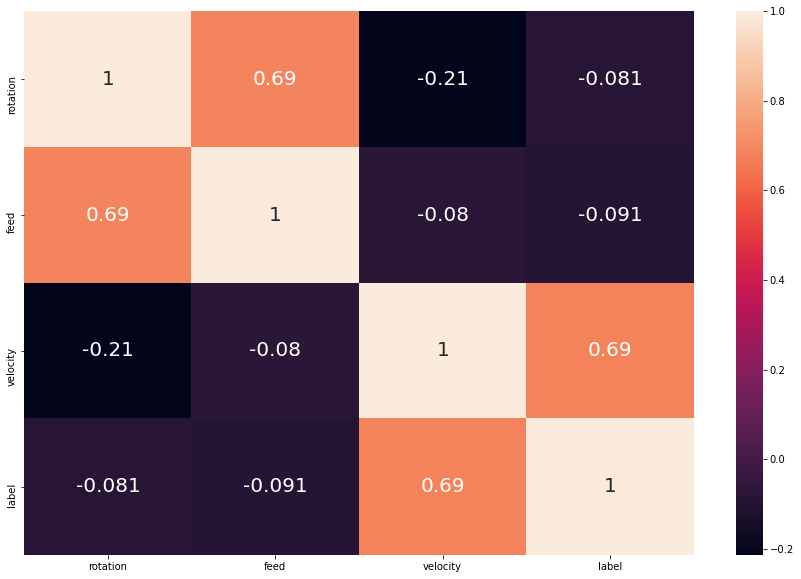

In [5]:
#데이터 구조 수정
input_rot = data[' CH 5 '].values
input_feed = data[' CH 6 '].values
input_vel = data[' CH 9 '].values
output_data = data[' CH 10 '].values
# plt.subplot(411)
# plt.plot(input_rot)
# plt.subplot(412)
# plt.plot(input_feed)
# plt.subplot(413)
# plt.plot(input_vel)
# plt.subplot(414)
# plt.plot(output_data)
# plt.show()

import seaborn as sns
data_mod = data.drop(['DateTime ', ' Elasped_Time(sec) ', ' CH 7 ', ' CH 8 ', ' CH 8-2 ', ' CH 8-3 '], axis='columns')
data_mod.rename(columns = {' CH 5 ' : 'rotation'}, inplace = True)
data_mod.rename(columns = {' CH 6 ' : 'feed'}, inplace = True)
#data_mod.rename(columns = {' CH 7 ' : 'attack'}, inplace = True)
data_mod.rename(columns = {' CH 9 ' : 'velocity'}, inplace = True)
data_mod.rename(columns = {' CH 10 ' : 'label'}, inplace = True)
print(data_mod)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data_mod.corr(),annot=True, annot_kws={"size": 20})

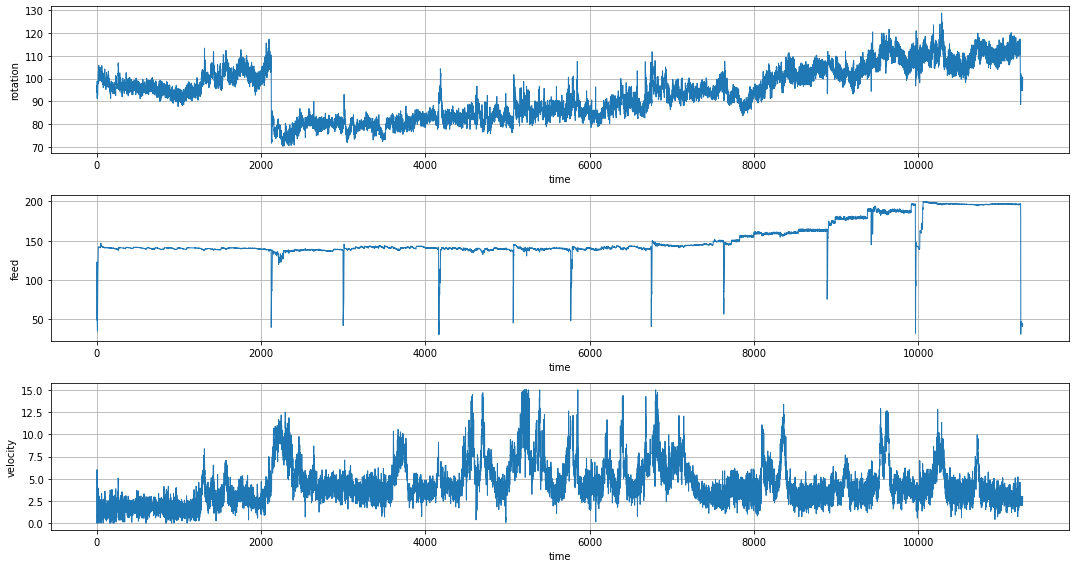

50 50


In [6]:
#데이터 확인
input_val1 = data_mod['rotation'].values
input_val2 = data_mod['feed'].values
input_val3 = data_mod['velocity'].values

#plt 속성
plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True

plt.subplot(311)
plt.plot(input_val1)
plt.xlabel('time')
plt.ylabel('rotation')
plt.subplot(312)
plt.plot(input_val2)
plt.xlabel('time')
plt.ylabel('feed')
plt.subplot(313)
plt.plot(input_val3)
plt.xlabel('time')
plt.ylabel('velocity')
plt.tight_layout()
plt.show()

#lstm 을 위한 데이터 구간 설정
seq_len = 50
sequence_length = seq_len + 0
print(seq_len, sequence_length)

In [7]:
#데이터셋을 RNN에 맞게 새롭게 편집 - x에 대해 - about result1 : rotation
result1 = []
print(len(input_val1))
for index in range(len(input_val1) - sequence_length):
    result1.append(input_val1[index:index + sequence_length])
print(type(result1), len(result1), len(result1[0]), sum(result1[4])/len(result1[4]))
print(result1[0], '\n', input_val1[1:1 + sequence_length])

#데이터들을 단순히 정규화 시키는 것 - x에 대해
#각 데이터셋의 가장 첫번째 값으로 정규화를 하는 것
import os

normalized_data1 = []
i1 = 0
for window in result1:
    i1 += 1
    average_val = sum(window)/float(len(window))
    print("%d\t%f\t%d\t%f"%(i1, sum(window), len(window), average_val))
    normalized_window=[(float(p)/average_val) for p in window]
    #os.system('Pause')
    normalized_data1.append(normalized_window)

result1 = np.array(normalized_data1)
print(len(result1))
print(len(result1[0]))
print(len(normalized_data1))
print(len(normalized_data1[0]))
print(result1[0])

11274
<class 'list'> 11224 50 100.15799999999999
[ 98.7  94.   96.9  96.7  91.2  93.1  97.1  96.6  94.7  92.5  92.9  95.1
  97.   98.8  97.9  97.6 100.6 101.9 103.1 100.5  97.9  98.2  99.8 105.8
 105.4 100.5 101.5 101.5 103.9 104.8 101.5 100.9 100.  102.5 103.9 100.3
 101.4  98.9 100.  102.4  99.4  99.2 102.7 102.2 104.7 104.1 100.6 102.4
 102.5 103.9] 
 [ 94.   96.9  96.7  91.2  93.1  97.1  96.6  94.7  92.5  92.9  95.1  97.
  98.8  97.9  97.6 100.6 101.9 103.1 100.5  97.9  98.2  99.8 105.8 105.4
 100.5 101.5 101.5 103.9 104.8 101.5 100.9 100.  102.5 103.9 100.3 101.4
  98.9 100.  102.4  99.4  99.2 102.7 102.2 104.7 104.1 100.6 102.4 102.5
 103.9 104.7]
1	4989.700000	50	99.794000
2	4995.700000	50	99.914000
3	5001.300000	50	100.026000
4	5004.800000	50	100.096000
5	5007.900000	50	100.158000
6	5017.700000	50	100.354000
7	5026.900000	50	100.538000
8	5028.300000	50	100.566000
9	5030.200000	50	100.604000
10	5034.400000	50	100.688000
11	5041.700000	50	100.834000
12	5054.500000	50	101.090000
1

2436	3959.300000	50	79.186000
2437	3961.800000	50	79.236000
2438	3963.200000	50	79.264000
2439	3962.100000	50	79.242000
2440	3963.700000	50	79.274000
2441	3970.300000	50	79.406000
2442	3979.300000	50	79.586000
2443	3984.400000	50	79.688000
2444	3983.700000	50	79.674000
2445	3985.200000	50	79.704000
2446	3986.300000	50	79.726000
2447	3989.500000	50	79.790000
2448	3988.200000	50	79.764000
2449	3991.200000	50	79.824000
2450	3995.300000	50	79.906000
2451	4000.600000	50	80.012000
2452	4004.600000	50	80.092000
2453	4004.500000	50	80.090000
2454	4009.100000	50	80.182000
2455	4013.000000	50	80.260000
2456	4016.400000	50	80.328000
2457	4015.000000	50	80.300000
2458	4015.700000	50	80.314000
2459	4021.600000	50	80.432000
2460	4027.500000	50	80.550000
2461	4034.000000	50	80.680000
2462	4036.500000	50	80.730000
2463	4040.700000	50	80.814000
2464	4043.000000	50	80.860000
2465	4043.800000	50	80.876000
2466	4039.900000	50	80.798000
2467	4041.700000	50	80.834000
2468	4042.500000	50	80.850000
2469	4044.

5003	4065.700000	50	81.314000
5004	4057.400000	50	81.148000
5005	4046.800000	50	80.936000
5006	4042.700000	50	80.854000
5007	4042.000000	50	80.840000
5008	4045.400000	50	80.908000
5009	4035.000000	50	80.700000
5010	4025.800000	50	80.516000
5011	4021.000000	50	80.420000
5012	4018.000000	50	80.360000
5013	4015.300000	50	80.306000
5014	4005.500000	50	80.110000
5015	4001.200000	50	80.024000
5016	3998.600000	50	79.972000
5017	3998.100000	50	79.962000
5018	3994.600000	50	79.892000
5019	3987.800000	50	79.756000
5020	3986.500000	50	79.730000
5021	3985.700000	50	79.714000
5022	3986.100000	50	79.722000
5023	3982.500000	50	79.650000
5024	3987.400000	50	79.748000
5025	3992.100000	50	79.842000
5026	3992.700000	50	79.854000
5027	3993.900000	50	79.878000
5028	4001.700000	50	80.034000
5029	4022.700000	50	80.454000
5030	4039.100000	50	80.782000
5031	4052.000000	50	81.040000
5032	4066.400000	50	81.328000
5033	4087.800000	50	81.756000
5034	4101.800000	50	82.036000
5035	4112.800000	50	82.256000
5036	4122.

7538	4808.500000	50	96.170000
7539	4809.800000	50	96.196000
7540	4815.800000	50	96.316000
7541	4818.600000	50	96.372000
7542	4823.000000	50	96.460000
7543	4822.200000	50	96.444000
7544	4823.800000	50	96.476000
7545	4825.700000	50	96.514000
7546	4827.500000	50	96.550000
7547	4828.100000	50	96.562000
7548	4828.100000	50	96.562000
7549	4832.400000	50	96.648000
7550	4835.900000	50	96.718000
7551	4839.200000	50	96.784000
7552	4841.100000	50	96.822000
7553	4844.000000	50	96.880000
7554	4847.700000	50	96.954000
7555	4853.800000	50	97.076000
7556	4854.800000	50	97.096000
7557	4855.800000	50	97.116000
7558	4861.200000	50	97.224000
7559	4865.100000	50	97.302000
7560	4867.300000	50	97.346000
7561	4867.000000	50	97.340000
7562	4870.200000	50	97.404000
7563	4875.800000	50	97.516000
7564	4881.600000	50	97.632000
7565	4880.600000	50	97.612000
7566	4881.300000	50	97.626000
7567	4886.700000	50	97.734000
7568	4891.200000	50	97.824000
7569	4894.600000	50	97.892000
7570	4894.100000	50	97.882000
7571	4899.

10087	5528.300000	50	110.566000
10088	5524.700000	50	110.494000
10089	5523.100000	50	110.462000
10090	5520.600000	50	110.412000
10091	5515.800000	50	110.316000
10092	5508.700000	50	110.174000
10093	5503.900000	50	110.078000
10094	5502.000000	50	110.040000
10095	5500.300000	50	110.006000
10096	5497.400000	50	109.948000
10097	5496.500000	50	109.930000
10098	5494.400000	50	109.888000
10099	5494.900000	50	109.898000
10100	5496.000000	50	109.920000
10101	5495.700000	50	109.914000
10102	5492.100000	50	109.842000
10103	5490.000000	50	109.800000
10104	5491.700000	50	109.834000
10105	5489.300000	50	109.786000
10106	5490.700000	50	109.814000
10107	5487.000000	50	109.740000
10108	5485.600000	50	109.712000
10109	5485.600000	50	109.712000
10110	5487.400000	50	109.748000
10111	5487.700000	50	109.754000
10112	5480.600000	50	109.612000
10113	5480.600000	50	109.612000
10114	5480.300000	50	109.606000
10115	5488.800000	50	109.776000
10116	5490.800000	50	109.816000
10117	5490.700000	50	109.814000
10118	54

In [8]:
#데이터셋을 RNN에 맞게 새롭게 편집 - x에 대해 - about result2 : feed
result2 = []
print(len(input_val2))
for index in range(len(input_val2) - sequence_length):
    result2.append(input_val2[index:index + sequence_length])
print(type(result2), len(result2), len(result2[0]), sum(result2[4])/len(result2[4]))
print(result2[0], '\n', input_val2[1:1 + sequence_length])

#데이터들을 단순히 정규화 시키는 것 - x에 대해
#각 데이터셋의 가장 첫번째 값으로 정규화를 하는 것
import os

normalized_data2 = []
i1 = 0
for window in result2:
    i1 += 1
    average_val = sum(window)/float(len(window))
    print("%d\t%f\t%d\t%f"%(i1, sum(window), len(window), average_val))
    normalized_window=[(float(p)/average_val) for p in window]
    #os.system('Pause')
    normalized_data2.append(normalized_window)

result2 = np.array(normalized_data2)
print(len(result2))
print(len(result2[0]))
print(len(normalized_data2))
print(len(normalized_data2[0]))
print(result2[0])

11274
<class 'list'> 11224 50 127.87999999999998
[ 48.8 114.4 122.9  71.2  50.3  42.   37.5  34.8  52.3  91.5  96.9 100.6
 107.  114.4 123.9 134.4 141.2 141.3 141.6 141.8 141.8 141.8 142.  141.9
 142.1 142.2 142.2 141.9 141.7 141.7 141.9 141.7 141.4 141.2 141.3 141.6
 141.2 141.1 141.1 141.1 141.3 141.1 140.9 140.9 141.9 143.2 144.5 145.4
 146.8 146.8] 
 [114.4 122.9  71.2  50.3  42.   37.5  34.8  52.3  91.5  96.9 100.6 107.
 114.4 123.9 134.4 141.2 141.3 141.6 141.8 141.8 141.8 142.  141.9 142.1
 142.2 142.2 141.9 141.7 141.7 141.9 141.7 141.4 141.2 141.3 141.6 141.2
 141.1 141.1 141.1 141.3 141.1 140.9 140.9 141.9 143.2 144.5 145.4 146.8
 146.8 146.4]
1	6174.500000	50	123.490000
2	6272.100000	50	125.442000
3	6301.800000	50	126.036000
4	6322.100000	50	126.442000
5	6394.000000	50	127.880000
6	6486.500000	50	129.730000
7	6587.500000	50	131.750000
8	6693.000000	50	133.860000
9	6801.000000	50	136.020000
10	6891.400000	50	137.828000
11	6942.600000	50	138.852000
12	6988.300000	50	139.766000

2592	6913.800000	50	138.276000
2593	6912.700000	50	138.254000
2594	6912.600000	50	138.252000
2595	6911.400000	50	138.228000
2596	6910.500000	50	138.210000
2597	6908.900000	50	138.178000
2598	6908.700000	50	138.174000
2599	6908.000000	50	138.160000
2600	6907.100000	50	138.142000
2601	6906.700000	50	138.134000
2602	6906.600000	50	138.132000
2603	6906.800000	50	138.136000
2604	6906.500000	50	138.130000
2605	6906.100000	50	138.122000
2606	6905.500000	50	138.110000
2607	6905.500000	50	138.110000
2608	6905.000000	50	138.100000
2609	6904.600000	50	138.092000
2610	6904.300000	50	138.086000
2611	6904.300000	50	138.086000
2612	6904.300000	50	138.086000
2613	6904.100000	50	138.082000
2614	6904.100000	50	138.082000
2615	6903.300000	50	138.066000
2616	6903.300000	50	138.066000
2617	6902.700000	50	138.054000
2618	6902.700000	50	138.054000
2619	6902.200000	50	138.044000
2620	6902.200000	50	138.044000
2621	6902.300000	50	138.046000
2622	6902.300000	50	138.046000
2623	6902.400000	50	138.048000
2624	690

5133	7024.000000	50	140.480000
5134	7021.900000	50	140.438000
5135	7019.200000	50	140.384000
5136	7016.800000	50	140.336000
5137	7015.300000	50	140.306000
5138	7014.100000	50	140.282000
5139	7011.300000	50	140.226000
5140	7007.800000	50	140.156000
5141	7006.500000	50	140.130000
5142	7006.000000	50	140.120000
5143	7004.500000	50	140.090000
5144	7002.000000	50	140.040000
5145	6998.100000	50	139.962000
5146	6995.600000	50	139.912000
5147	6994.100000	50	139.882000
5148	6993.900000	50	139.878000
5149	6993.400000	50	139.868000
5150	6989.800000	50	139.796000
5151	6985.500000	50	139.710000
5152	6981.500000	50	139.630000
5153	6978.800000	50	139.576000
5154	6976.800000	50	139.536000
5155	6972.800000	50	139.456000
5156	6969.100000	50	139.382000
5157	6965.200000	50	139.304000
5158	6963.500000	50	139.270000
5159	6960.300000	50	139.206000
5160	6957.900000	50	139.158000
5161	6956.600000	50	139.132000
5162	6956.600000	50	139.132000
5163	6956.000000	50	139.120000
5164	6955.100000	50	139.102000
5165	695

7662	7287.200000	50	145.744000
7663	7287.700000	50	145.754000
7664	7288.800000	50	145.776000
7665	7289.800000	50	145.796000
7666	7289.200000	50	145.784000
7667	7288.000000	50	145.760000
7668	7287.800000	50	145.756000
7669	7287.000000	50	145.740000
7670	7285.000000	50	145.700000
7671	7283.100000	50	145.662000
7672	7282.600000	50	145.652000
7673	7283.200000	50	145.664000
7674	7283.200000	50	145.664000
7675	7282.800000	50	145.656000
7676	7283.000000	50	145.660000
7677	7283.500000	50	145.670000
7678	7283.600000	50	145.672000
7679	7283.100000	50	145.662000
7680	7283.000000	50	145.660000
7681	7285.600000	50	145.712000
7682	7289.700000	50	145.794000
7683	7293.200000	50	145.864000
7684	7295.900000	50	145.918000
7685	7299.100000	50	145.982000
7686	7304.000000	50	146.080000
7687	7309.500000	50	146.190000
7688	7313.700000	50	146.274000
7689	7318.200000	50	146.364000
7690	7323.600000	50	146.472000
7691	7329.300000	50	146.586000
7692	7333.500000	50	146.670000
7693	7337.400000	50	146.748000
7694	734

10194	9882.900000	50	197.658000
10195	9881.400000	50	197.628000
10196	9879.800000	50	197.596000
10197	9878.400000	50	197.568000
10198	9877.500000	50	197.550000
10199	9876.500000	50	197.530000
10200	9875.000000	50	197.500000
10201	9873.400000	50	197.468000
10202	9872.300000	50	197.446000
10203	9871.600000	50	197.432000
10204	9870.300000	50	197.406000
10205	9869.000000	50	197.380000
10206	9867.400000	50	197.348000
10207	9866.400000	50	197.328000
10208	9865.900000	50	197.318000
10209	9864.600000	50	197.292000
10210	9862.700000	50	197.254000
10211	9860.900000	50	197.218000
10212	9860.000000	50	197.200000
10213	9859.000000	50	197.180000
10214	9857.400000	50	197.148000
10215	9855.500000	50	197.110000
10216	9854.200000	50	197.084000
10217	9853.500000	50	197.070000
10218	9852.300000	50	197.046000
10219	9850.700000	50	197.014000
10220	9849.200000	50	196.984000
10221	9848.600000	50	196.972000
10222	9848.400000	50	196.968000
10223	9846.900000	50	196.938000
10224	9845.300000	50	196.906000
10225	98

In [9]:
#데이터셋을 RNN에 맞게 새롭게 편집 - x에 대해 - about result3 : velocity
result3 = []
print(len(input_val3))
for index in range(len(input_val3) - sequence_length):
    result3.append(input_val3[index:index + sequence_length])
print(type(result3), len(result3), len(result3[0]), sum(result3[4])/len(result3[4]))
print(result3[0], '\n', input_val3[1:1 + sequence_length])

#데이터들을 단순히 정규화 시키는 것 - x에 대해
#각 데이터셋의 가장 첫번째 값으로 정규화를 하는 것
#특이한 점은 output까지 정규화를 시행함
import os

normalized_data3 = []
i1 = 0
for window in result3:
    i1 += 1
    average_val = sum(window)/float(len(window))
    print("%d\t%f\t%d\t%f"%(i1, sum(window), len(window), average_val))
    normalized_window=[(float(p)/average_val) for p in window]
    #os.system('Pause')
    normalized_data3.append(normalized_window)

result3 = np.array(normalized_data3)
print(len(result3))
print(len(result3[0]))
print(len(normalized_data3))
print(len(normalized_data3[0]))
print(result3[0])

11274
<class 'list'> 11224 50 1.4884
[0.   2.92 6.02 1.56 0.66 0.57 0.   1.04 1.17 1.74 2.55 1.05 1.75 1.74
 2.7  3.95 3.07 2.73 2.21 2.68 0.37 1.62 1.29 2.73 0.74 0.   0.82 0.91
 1.31 1.23 0.44 2.11 3.04 2.08 0.62 1.21 0.77 1.92 0.3  1.15 2.66 0.16
 1.17 1.18 2.17 2.17 0.45 2.31 2.06 1.36] 
 [2.92 6.02 1.56 0.66 0.57 0.   1.04 1.17 1.74 2.55 1.05 1.75 1.74 2.7
 3.95 3.07 2.73 2.21 2.68 0.37 1.62 1.29 2.73 0.74 0.   0.82 0.91 1.31
 1.23 0.44 2.11 3.04 2.08 0.62 1.21 0.77 1.92 0.3  1.15 2.66 0.16 1.17
 1.18 2.17 2.17 0.45 2.31 2.06 1.36 1.65]
1	80.460000	50	1.609200
2	82.110000	50	1.642200
3	79.190000	50	1.583800
4	73.970000	50	1.479400
5	74.420000	50	1.488400
6	75.870000	50	1.517400
7	77.810000	50	1.556200
8	78.280000	50	1.565600
9	78.340000	50	1.566800
10	80.510000	50	1.610200
11	79.090000	50	1.581800
12	77.920000	50	1.558400
13	79.380000	50	1.587600
14	79.200000	50	1.584000
15	78.820000	50	1.576400
16	77.610000	50	1.552200
17	75.060000	50	1.501200
18	73.680000	50	1.473600
19	71.83000

2475	262.570000	50	5.251400
2476	262.850000	50	5.257000
2477	261.690000	50	5.233800
2478	258.390000	50	5.167800
2479	256.670000	50	5.133400
2480	253.260000	50	5.065200
2481	250.110000	50	5.002200
2482	248.220000	50	4.964400
2483	248.850000	50	4.977000
2484	245.760000	50	4.915200
2485	243.100000	50	4.862000
2486	239.930000	50	4.798600
2487	239.840000	50	4.796800
2488	234.720000	50	4.694400
2489	228.980000	50	4.579600
2490	224.960000	50	4.499200
2491	225.370000	50	4.507400
2492	225.600000	50	4.512000
2493	224.940000	50	4.498800
2494	224.840000	50	4.496800
2495	224.740000	50	4.494800
2496	222.630000	50	4.452600
2497	219.660000	50	4.393200
2498	217.370000	50	4.347400
2499	214.960000	50	4.299200
2500	212.690000	50	4.253800
2501	211.560000	50	4.231200
2502	210.560000	50	4.211200
2503	209.330000	50	4.186600
2504	209.920000	50	4.198400
2505	208.850000	50	4.177000
2506	207.150000	50	4.143000
2507	206.080000	50	4.121600
2508	205.130000	50	4.102600
2509	202.200000	50	4.044000
2510	202.030000	50	4

5073	339.960000	50	6.799200
5074	343.030000	50	6.860600
5075	345.790000	50	6.915800
5076	346.840000	50	6.936800
5077	347.530000	50	6.950600
5078	348.660000	50	6.973200
5079	349.700000	50	6.994000
5080	353.810000	50	7.076200
5081	356.470000	50	7.129400
5082	357.840000	50	7.156800
5083	359.580000	50	7.191600
5084	360.620000	50	7.212400
5085	360.130000	50	7.202600
5086	357.570000	50	7.151400
5087	357.430000	50	7.148600
5088	359.170000	50	7.183400
5089	363.130000	50	7.262600
5090	361.690000	50	7.233800
5091	361.190000	50	7.223800
5092	364.810000	50	7.296200
5093	368.010000	50	7.360200
5094	370.000000	50	7.400000
5095	371.460000	50	7.429200
5096	371.110000	50	7.422200
5097	371.950000	50	7.439000
5098	377.230000	50	7.544600
5099	379.260000	50	7.585200
5100	382.640000	50	7.652800
5101	384.740000	50	7.694800
5102	387.520000	50	7.750400
5103	388.050000	50	7.761000
5104	388.670000	50	7.773400
5105	388.310000	50	7.766200
5106	389.450000	50	7.789000
5107	390.230000	50	7.804600
5108	396.600000	50	7

6460	195.200000	50	3.904000
6461	193.450000	50	3.869000
6462	192.400000	50	3.848000
6463	191.950000	50	3.839000
6464	190.650000	50	3.813000
6465	190.550000	50	3.811000
6466	189.750000	50	3.795000
6467	187.870000	50	3.757400
6468	189.010000	50	3.780200
6469	186.670000	50	3.733400
6470	187.250000	50	3.745000
6471	186.460000	50	3.729200
6472	185.240000	50	3.704800
6473	183.280000	50	3.665600
6474	183.640000	50	3.672800
6475	184.740000	50	3.694800
6476	183.360000	50	3.667200
6477	183.670000	50	3.673400
6478	183.400000	50	3.668000
6479	182.910000	50	3.658200
6480	183.500000	50	3.670000
6481	183.580000	50	3.671600
6482	182.010000	50	3.640200
6483	182.760000	50	3.655200
6484	183.180000	50	3.663600
6485	185.380000	50	3.707600
6486	186.610000	50	3.732200
6487	185.760000	50	3.715200
6488	186.530000	50	3.730600
6489	186.290000	50	3.725800
6490	185.900000	50	3.718000
6491	185.080000	50	3.701600
6492	184.490000	50	3.689800
6493	183.750000	50	3.675000
6494	182.870000	50	3.657400
6495	181.300000	50	3

9063	221.490000	50	4.429800
9064	224.000000	50	4.480000
9065	228.560000	50	4.571200
9066	231.500000	50	4.630000
9067	235.330000	50	4.706600
9068	238.420000	50	4.768400
9069	239.540000	50	4.790800
9070	241.470000	50	4.829400
9071	242.330000	50	4.846600
9072	244.570000	50	4.891400
9073	247.120000	50	4.942400
9074	250.200000	50	5.004000
9075	252.990000	50	5.059800
9076	254.290000	50	5.085800
9077	256.020000	50	5.120400
9078	257.270000	50	5.145400
9079	258.750000	50	5.175000
9080	259.060000	50	5.181200
9081	261.020000	50	5.220400
9082	264.420000	50	5.288400
9083	267.330000	50	5.346600
9084	268.930000	50	5.378600
9085	271.670000	50	5.433400
9086	274.490000	50	5.489800
9087	277.230000	50	5.544600
9088	279.360000	50	5.587200
9089	281.290000	50	5.625800
9090	280.710000	50	5.614200
9091	283.660000	50	5.673200
9092	285.730000	50	5.714600
9093	286.330000	50	5.726600
9094	285.880000	50	5.717600
9095	288.090000	50	5.761800
9096	288.620000	50	5.772400
9097	288.840000	50	5.776800
9098	288.630000	50	5

11224
50
11224
50
[0.         1.81456624 3.74098931 0.9694258  0.41014169 0.35421327
 0.         0.64628387 0.72706935 1.08128262 1.58463833 0.65249814
 1.08749689 1.08128262 1.67785235 2.45463584 1.90778026 1.69649515
 1.37335322 1.66542381 0.22992791 1.00671141 0.80164057 1.69649515
 0.45985583 0.         0.50956997 0.56549838 0.8140691  0.76435496
 0.27342779 1.31121054 1.88913746 1.29256774 0.38528461 0.75192642
 0.47849863 1.19313945 0.18642804 0.71464082 1.65299528 0.09942829
 0.72706935 0.73328362 1.34849615 1.34849615 0.27964206 1.4354959
 1.2801392  0.84514044]


[0 0 0 ... 0 0 0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

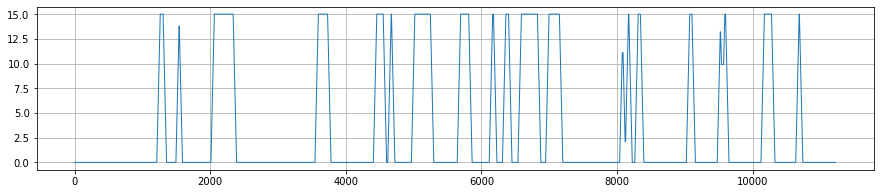

In [10]:
# 데이터셋을 RNN에 맞게 새롭게 편집하는 부분 - y 에 대해
output_data = data_mod['label'].values
print(output_data)
result_y = []
for index in range(len(output_data) - sequence_length):
    result_y.append(sum(output_data[index:index + sequence_length])/len(output_data[index:index + sequence_length])) 
print(result_y)
print(len(result_y))
plt.rcParams["figure.figsize"] = (15,3)
plt.plot(result_y)
#for index in range(len(output_data) - sequence_length):
#    result_x.append(mid_prices[index:index + sequence_length])

10102
10102
1122
1122
1122


((10102, 50, 1), (10102,), (1122, 50, 1), (1122,))

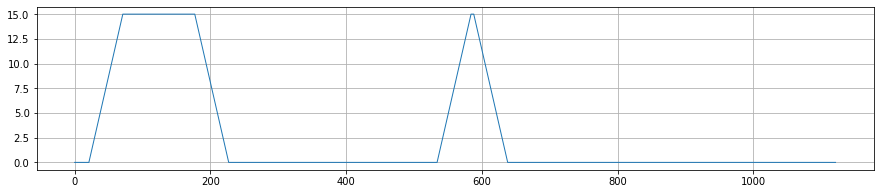

In [11]:
#about rotation
#학습에 앞서 데이터를 input과 output 으로 구분
#각 데이터셋의 90%를 train으로, 10%를 test로 사용
result_use = result1
row = int(round(result_use.shape[0]*0.9))
x_train = result_use[:row,:]
y_train = result_y[:row]

#51개의 데이터를 input value(x_train, 50)와 output value(y_train, 1)로 나눔
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))#1차원 배열들을 2차원 배열로 변경
y_train = np.array(y_train)
print(len(x_train))
print(len(y_train))

# np.random.shuffle(train)

x_test = result_use[row:,:]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = result_use[row:,-1]
y_test = np.array(y_test)
y_test1 = result_y[row:]
y_test1 = np.array(y_test1)
print(len(x_test))
print(len(y_test))
print(len(y_test1))
plt.plot(y_test1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [12]:
model1 = Sequential()
model1.add(LSTM(50, return_sequences=True,input_shape=(50,1)))
model1.add(LSTM(64, return_sequences=False))
model1.add(Dense(1,activation='linear'))#다음날 하나의 데이터만 예측
model1.compile(loss='mse',optimizer='rmsprop')
model1.summary()
model1.fit(x_train, y_train, validation_data=(x_test,y_test1),batch_size=10,epochs=20)
#원래 y_test를 사용했었는데, 그러다보니 val_loss가 줄어들지 않게 됬던것은 당연한것이다.
#y_test1을 사용하고 나서 val_loss가줄어들게 된것도 당연하다.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1011/1011 [==============================] - 15s 12ms/step - loss: 34.8541 - val_loss: 27.5484
Epoch 2/20
1011/1011 [==============================] - 12s 12ms/step - loss: 33.0054 - val_loss: 28.1902
Epoch 3/20
1011/1011 [==============================] - 12s 12ms/step - loss: 33.5314 - val_loss: 27.8060
Epoch 4/20
1011/1011 [==============================] - 12s 12ms

10102
10102
1122
1122
1122


((10102, 50, 1), (10102,), (1122, 50, 1), (1122,))

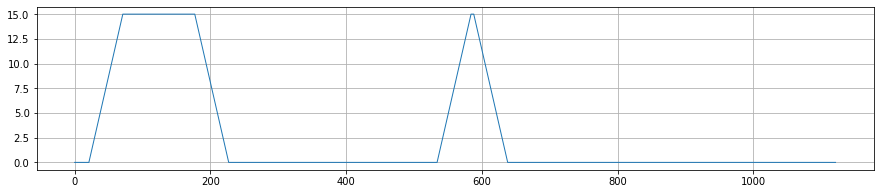

In [13]:
#about feed
#학습에 앞서 데이터를 input과 output 으로 구분하는 것
#각 데이터셋의 90%를 train으로, 10%를 test로 사용
result_use = result2
row = int(round(result_use.shape[0]*0.9))
x_train = result_use[:row,:]
y_train = result_y[:row]

#51개의 데이터를 input value(x_train, 50)와 output value(y_train, 1)로 나눔
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))#1차원 배열들을 2차원 배열로 변경
y_train = np.array(y_train)
print(len(x_train))
print(len(y_train))

# np.random.shuffle(train)

x_test = result_use[row:,:]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = result_use[row:,-1]
y_test = np.array(y_test)
y_test1 = result_y[row:]
y_test1 = np.array(y_test1)
print(len(x_test))
print(len(y_test))
print(len(y_test1))
plt.plot(y_test1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [14]:
model2 = Sequential()
model2.add(LSTM(50, return_sequences=True,input_shape=(50,1)))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dense(1,activation='linear'))#다음날 하나의 데이터만 예측
model2.compile(loss='mse',optimizer='rmsprop')
model2.summary()
model2.fit(x_train, y_train, validation_data=(x_test,y_test1),batch_size=10,epochs=20)
#원래 y_test를 사용했었는데, 그러다보니 val_loss가 줄어들지 않게 됬던것은 당연한것이다.
#y_test1을 사용하고 나서 val_loss가줄어들게 된것도 당연하다.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1011/1011 [==============================] - 15s 12ms/step - loss: 33.5503 - val_loss: 28.0988
Epoch 2/20
1011/1011 [==============================] - 12s 12ms/step - loss: 33.7728 - val_loss: 27.8073
Epoch 3/20
1011/1011 [==============================] - 12s 12ms/step - loss: 33.3904 - val_loss: 27.9627
Epoch 4/20
1011/1011 [==============================] - 12s 12

10102
10102
1122
1122
1122


((10102, 50, 1), (10102,), (1122, 50, 1), (1122,))

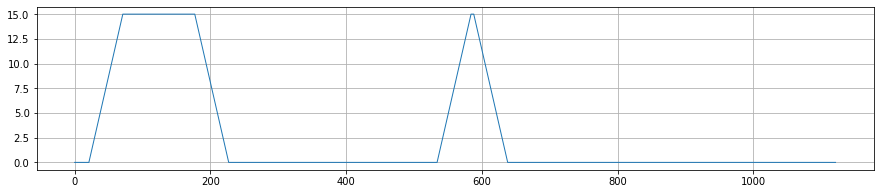

In [15]:
#about velocity
#학습에 앞서 데이터를 input과 output 으로 구분하는 것
#각 데이터셋의 90%를 train으로, 10%를 test로 사용
result_use = result3
row = int(round(result_use.shape[0]*0.9))
x_train = result_use[:row,:]
y_train = result_y[:row]

#51개의 데이터를 input value(x_train, 50)와 output value(y_train, 1)로 나눔
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))#1차원 배열들을 2차원 배열로 변경
y_train = np.array(y_train)
print(len(x_train))
print(len(y_train))

# np.random.shuffle(train)

x_test = result_use[row:,:]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = result_use[row:,-1]
y_test = np.array(y_test)
y_test1 = result_y[row:]
y_test1 = np.array(y_test1)
print(len(x_test))
print(len(y_test))
print(len(y_test1))
plt.plot(y_test1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [16]:
model3 = Sequential()
model3.add(LSTM(50, return_sequences=True,input_shape=(50,1)))
model3.add(LSTM(64, return_sequences=False))
model3.add(Dense(1,activation='linear'))#다음날 하나의 데이터만 예측
model3.compile(loss='mse',optimizer='rmsprop')
model3.summary()
model3.fit(x_train, y_train, validation_data=(x_test,y_test1),batch_size=10,epochs=20)
#원래 y_test를 사용했었는데, 그러다보니 val_loss가 줄어들지 않게 됬던것은 당연한것이다.
#y_test1을 사용하고 나서 val_loss가줄어들게 된것도 당연하다.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1011/1011 [==============================] - 14s 12ms/step - loss: 34.2714 - val_loss: 28.7713
Epoch 2/20
1011/1011 [==============================] - 12s 12ms/step - loss: 32.6035 - val_loss: 35.2449
Epoch 3/20
1011/1011 [==============================] - 12s 12ms/step - loss: 30.4700 - val_loss: 20.7847
Epoch 4/20
1011/1011 [==============================] - 12s 12

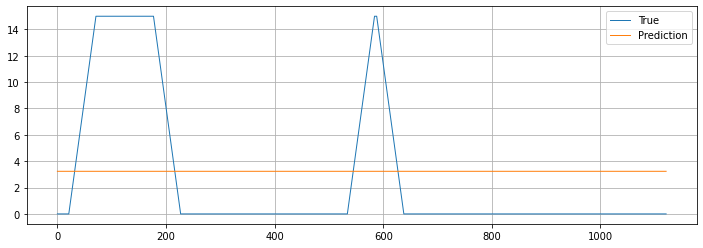

In [17]:
#10개 데이터 단위로 총 20번을 반복 학습하는 모델  
pred1=model1.predict(x_test)
pred1
fig=plt.figure(facecolor='white', figsize=(12,4))
ax=fig.add_subplot(111)
ax.plot(y_test1,label='True')
ax.plot(pred1,label='Prediction')
ax.legend()
plt.show()

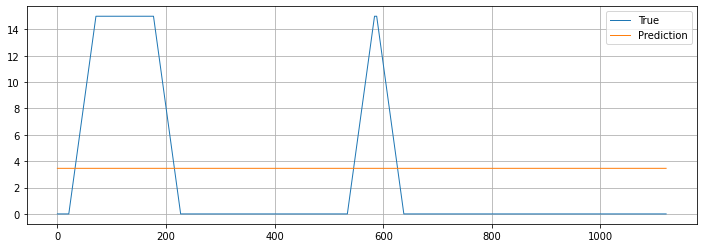

In [18]:
#10개 데이터 단위로 총 20번을 반복 학습하는 모델  
pred2=model2.predict(x_test)
pred2
fig=plt.figure(facecolor='white', figsize=(12,4))
ax=fig.add_subplot(111)
ax.plot(y_test1,label='True')
ax.plot(pred2,label='Prediction')
ax.legend()
plt.show()

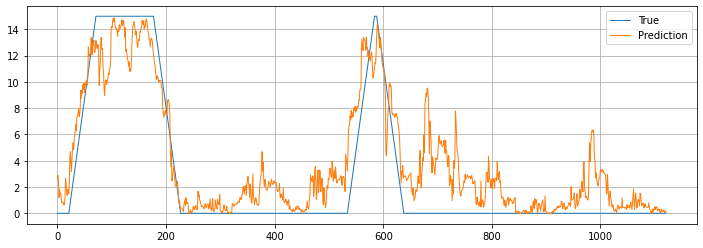

In [19]:
#10개 데이터 단위로 총 20번을 반복 학습하는 모델  
pred3=model3.predict(x_test)
pred3
fig=plt.figure(facecolor='white', figsize=(12,4))
ax=fig.add_subplot(111)
ax.plot(y_test1,label='True')
ax.plot(pred3,label='Prediction')
ax.legend()
plt.show()

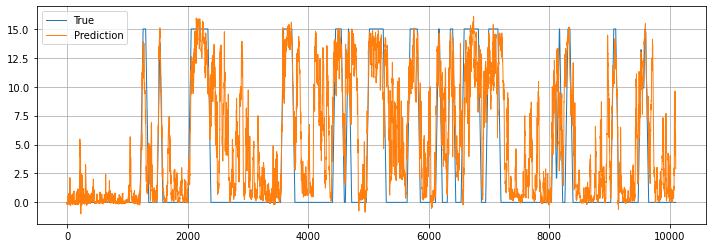

In [20]:
#10개 데이터 단위로 총 20번을 반복 학습하는 모델  
pred=model3.predict(x_train)
pred
fig=plt.figure(facecolor='white', figsize=(12,4))
ax=fig.add_subplot(111)
ax.plot(y_train,label='True')
ax.plot(pred,label='Prediction')
ax.legend()
plt.show()